In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn import datasets
from sklearn.model_selection import train_test_split
from imodels import HSTreeClassifier, HSTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Regression

In [4]:
X_r, y_r = datasets.load_diabetes(return_X_y=True, as_frame=True)

# Train test split
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.2, random_state=1234)

## Vanilla sklearn

In [5]:
reg_sklearn = DecisionTreeRegressor(max_depth=2, random_state=42)
reg_sklearn.fit(X_r_train, y_r_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [6]:
y_r_pred = reg_sklearn.predict(X_r_test)

In [7]:
rmse_sklearn = mean_squared_error(y_r_test, y_r_pred, squared=True)
rmse_sklearn

3882.7794517024054

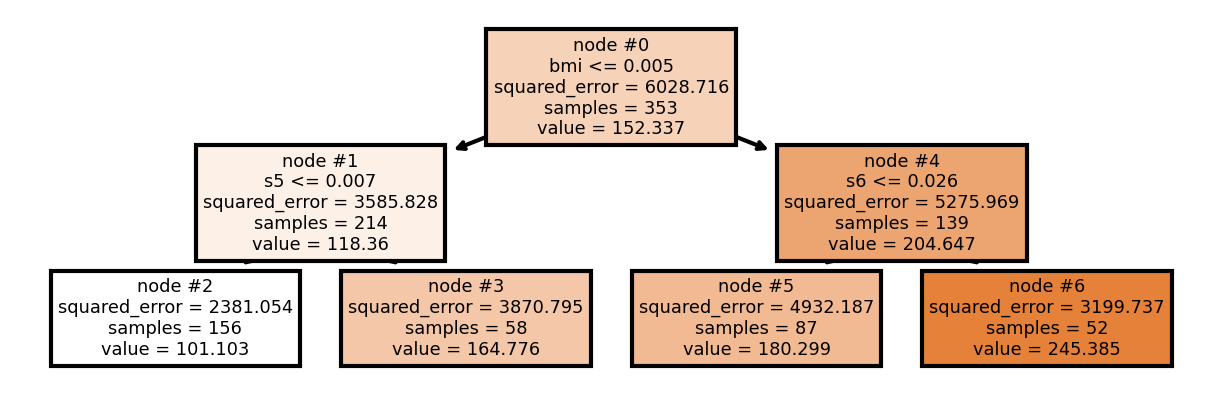

In [8]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(reg_sklearn, feature_names=X_r_train.columns, node_ids=True, filled=True, ax=ax);

## Vanilla HS from imodels package

In [9]:
from sklearn.base import clone
reg_sklearn_forHS = clone(reg_sklearn)

In [10]:
reg_hs = HSTreeRegressor(reg_sklearn_forHS, reg_param=1., shrinkage_scheme_="node_based")

reg_hs.fit(X_r_train, y_r_train)

In [11]:
y_r_pred_imodels = reg_hs.predict(X_r_test)

In [12]:
rmse_imodels = mean_squared_error(y_r_test, y_r_pred_imodels, squared=True)
rmse_imodels

3877.1962740983845

In [13]:
reg_hs.get_params()

{'reg_param': 1.0,
 'estimator_': DecisionTreeRegressor(max_depth=2, random_state=42),
 'shrinkage_scheme_': 'node_based'}

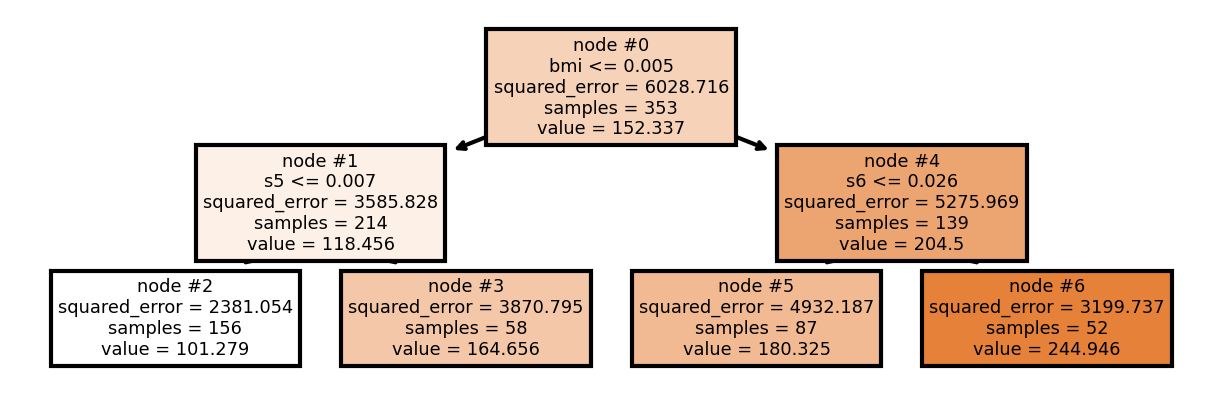

In [14]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(reg_hs.estimator_, feature_names=X_r_train.columns, node_ids=True, filled=True, ax=ax);

## TreeModel from Scratch Dingyi

### Without HS

In [15]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/ExplainableAI/RF_from_scratch/utils")

In [16]:
#tree functions
from helper_function import decision_tree_algorithm, decision_tree_predictions

/Users/philippheitmann/.pyenv/versions/3.10.6/envs/lewagon_current/lib/python3.10/site-packages/treeinterpreter/treeinterpreter.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.17"):
/Users/philippheitmann/.pyenv/versions/3.10.6/envs/lewagon_current/lib/python3.10/site-packages/treeinterpreter/treeinterpreter.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.17"):


In [17]:
tree, feature_gain, y_list = decision_tree_algorithm(X_r_train, y_r_train, 1, max_depth=2, random_state=42)

In [18]:
y_list

{0: [0, 353, 152.3371104815864],
 1: [1, 214, 118.35981308411215],
 2: [2, 156, 102.80899070593583],
 3: [2, 58, 163.63973072740862],
 4: [1, 139, 204.6474820143885],
 5: [2, 87, 180.4919298459266],
 6: [2, 52, 241.20952252093653]}

In [19]:
tree

{'bmi <= 0.005111072639941301 with num of samples 353 and current y 152.3371104815864 and above y {0: [0, 353, 152.3371104815864]}': [{'s5 <= 0.006616937565137579 with num of samples 214 and current y 118.35981308411215 and above y {0: [0, 353, 152.3371104815864], 1: [1, 214, 118.35981308411215]}': [102.80899070593583,
    163.63973072740862]},
  {'s6 <= 0.025845997445957995 with num of samples 139 and current y 204.6474820143885 and above y {0: [0, 353, 152.3371104815864], 1: [1, 214, 118.35981308411215], 2: [2, 156, 102.80899070593583], 3: [2, 58, 163.63973072740862], 4: [1, 139, 204.6474820143885]}': [180.4919298459266,
    241.20952252093653]}]}

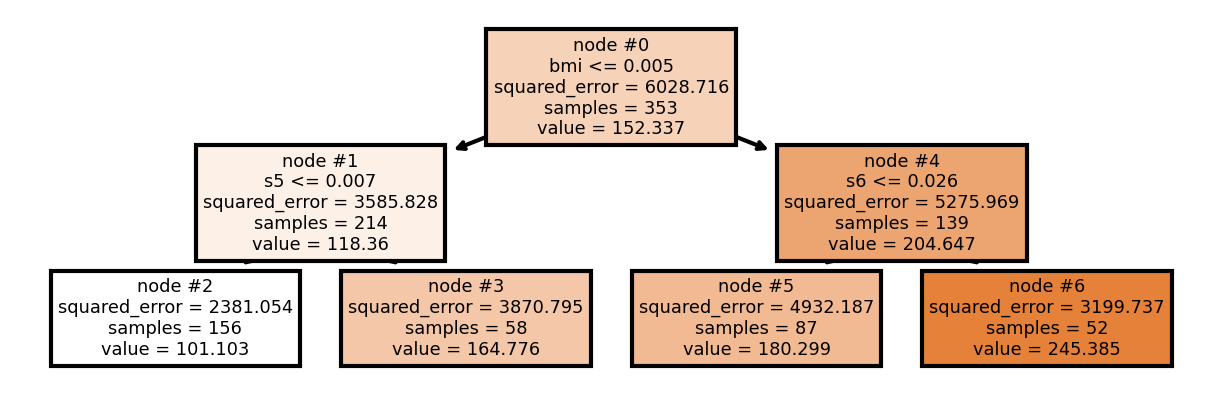

In [20]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(reg_sklearn, feature_names=X_r_train.columns, node_ids=True, filled=True, ax=ax);

In [21]:
node_values_dingyi = [node[2] for node in y_list.values()]
node_values_dingyi

[152.3371104815864,
 118.35981308411215,
 102.80899070593583,
 163.63973072740862,
 204.6474820143885,
 180.4919298459266,
 241.20952252093653]

In [22]:
# node values from sklearn without HS: 
node_values_sk = np.concatenate(reg_sklearn.tree_.value).ravel().tolist()
node_values_sk

[152.3371104815864,
 118.35981308411215,
 101.1025641025641,
 164.77586206896552,
 204.6474820143885,
 180.29885057471265,
 245.3846153846154]

In [23]:
for i, j in zip(node_values_sk, node_values_dingyi):
    print(i-j)

0.0
0.0
-1.7064266033717246
1.1361313415569043
0.0
-0.1930792712139464
4.175092863678856


The values from Dingyi's code are not equal to the values from sklearn?!

## TreeModels from Scratch 

### Without HS

In [295]:
# Train DecisionTree from scratch
reg_tree = DecisionTree(max_depth=2, treetype="regression", HS_lambda=1, HShrinkage=False, random_state=42)
reg_tree.fit(X_r_train, y_r_train.values)

In [296]:
# Predict
y_r_pred = reg_tree.predict(X_r_test)

In [297]:
rmse_tree_scratch = mean_squared_error(y_r_test, y_r_pred, squared=True)
rmse_tree_scratch

3882.7794517024054

In [298]:
rmse_tree_scratch ==rmse_sklearn

True

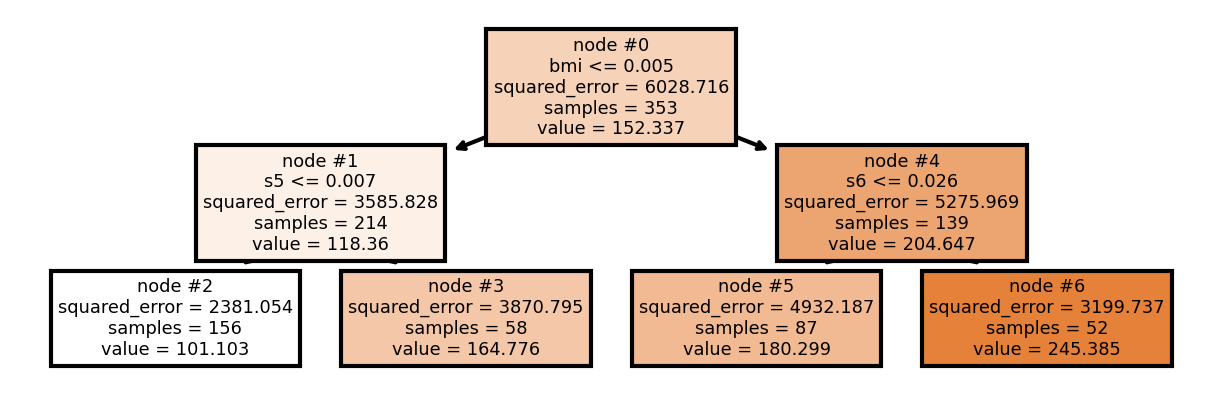

In [299]:
# Comparison with sklearn
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(reg_sklearn, feature_names=X_r_train.columns, node_ids=True, filled=True, ax=ax);

In [300]:
reg_tree.node_id_dict

{0: {'node': <DecisionTree.Node at 0x12cb108e0>,
  'id': 0,
  'depth': 0,
  'feature': 'bmi',
  'is_leaf_node': False,
  'threshold': 0.005111072639941301,
  'gini': 6028.716384851817,
  'samples': 353,
  'value': 152.3371104815864},
 1: {'node': <DecisionTree.Node at 0x12cb123b0>,
  'id': 1,
  'depth': 1,
  'feature': 's5',
  'is_leaf_node': False,
  'threshold': 0.006616937565137579,
  'gini': 3585.8284784697353,
  'samples': 214,
  'value': 118.35981308411215},
 2: {'node': <DecisionTree.Node at 0x12cae7c70>,
  'id': 2,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 2381.053583168968,
  'samples': 156,
  'value': 101.1025641025641},
 3: {'node': <DecisionTree.Node at 0x12ad45b40>,
  'id': 3,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 3870.7945897740783,
  'samples': 58,
  'value': 164.77586206896552},
 4: {'node': <DecisionTree.Node at 0x12cb13df0>,
  'id': 4,
  'depth': 1,
  'feature': 's6',
  'is

In [301]:
reg_sklearn.tree_.n_outputs

1

In [302]:
reg_sklearn.tree_.weighted_n_node_samples

array([353., 214., 156.,  58., 139.,  87.,  52.])

In [303]:
reg_sklearn.tree_.max_n_classes

1

In [304]:
# node values from scratch without HS: 
node_values_scratch = [node.value for node in reg_tree.node_list]
node_values_scratch

[152.3371104815864,
 118.35981308411215,
 101.1025641025641,
 164.77586206896552,
 204.6474820143885,
 180.29885057471265,
 245.3846153846154]

In [305]:
for i, j in zip(node_values_sk, node_values_scratch):
    print(i-j)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


They are equal!

In [306]:
reg_sklearn.feature_importances_

array([0.        , 0.        , 0.66980883, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18300082, 0.14719035])

In [307]:
reg_tree.feature_importances_

array([0.        , 0.        , 0.66980883, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18300082, 0.14719035])

In [269]:
feat_imp_p_node = np.nan_to_num(np.array([i.gain for i in reg_tree.node_list], dtype=float))
feat_imp_p_node

array([1777.36505054,  485.60013941,    0.        ,    0.        ,
        390.57560635,    0.        ,    0.        ])

In [244]:
X_r_train.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [241]:
a

array([1777.36505054,  485.60013941,    0.        ,    0.        ,
        390.57560635,    0.        ,    0.        ])

In [242]:
# Normalize information gain
np.divide(a,(np.sum(a)))

array([0.66980883, 0.18300082, 0.        , 0.        , 0.14719035,
       0.        , 0.        ])

In [243]:
# TODO: Update information gain (normalize)
# Add .feature_importances_ (information_gain_scaled_) as class attribute 
# Add .features_in_ as class attribute 
# Add max_depth() as class function 
# Add get_n_leaves() as class function 

In [291]:
reg_sklearn.feature_importances_

array([0.        , 0.        , 0.66980883, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18300082, 0.14719035])

In [268]:
feature_numbers = [i.feature for i in reg_tree.node_list if i.feature is not None]

[2, 8, 9]

In [273]:
features_list = [i.feature for i in reg_tree.node_list]
features_list

[2, 8, None, None, 9, None, None]

In [270]:
feat_imp_p_node = np.nan_to_num(np.array([i.gain for i in reg_tree.node_list], dtype=float))
feat_imp_p_node

array([1777.36505054,  485.60013941,    0.        ,    0.        ,
        390.57560635,    0.        ,    0.        ])

In [276]:
feature_importance = np.zeros(7)

In [277]:
feature_importance

array([0., 0., 0., 0., 0., 0., 0.])

In [285]:
feature_importance = np.zeros(reg_tree.n_features)
for feat_num, feat_imp in zip(features_list, feat_imp_p_node):
    if feat_num is not None:
        feature_importance[feat_num]=feat_imp

2 1777.3650505423875
8 485.60013940869084
9 390.5756063494056


In [286]:
feature_importance

array([   0.        ,    0.        , 1777.36505054,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        485.60013941,  390.57560635])

### With HS

In [41]:
# Train DecisionTree from scratch
reg_treeHS = DecisionTree(max_depth=2, treetype="regression", HS_lambda=1., HShrinkage=True, random_state=42)
reg_treeHS.fit(X_r_train, y_r_train.values)

In [42]:
# Predict
y_r_pred_scratch = reg_treeHS.predict(X_r_test)

In [43]:
rmse_tree_scratchHS = mean_squared_error(y_r_test, y_r_pred_scratch, squared=True)
rmse_tree_scratchHS

3877.1962740983845

In [44]:
rmse_tree_scratchHS ==rmse_imodels

True

In [45]:
print(rmse_tree_scratchHS)
print(rmse_imodels)

3877.1962740983845
3877.1962740983845


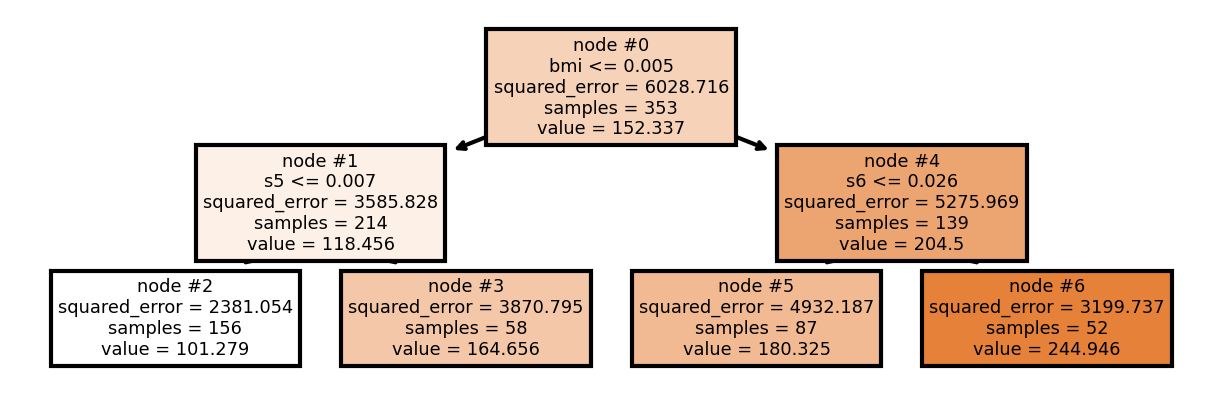

In [46]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(reg_hs.estimator_, feature_names=X_r_train.columns, node_ids=True, filled=True, ax=ax);

In [47]:
reg_treeHS.node_id_dict

{0: {'node': <DecisionTree.Node at 0x12abe82b0>,
  'id': 0,
  'depth': 0,
  'feature': 'bmi',
  'is_leaf_node': False,
  'threshold': 0.005111072639941301,
  'gini': 6028.716384851817,
  'samples': 353,
  'value': 152.3371104815864},
 1: {'node': <DecisionTree.Node at 0x12abe8040>,
  'id': 1,
  'depth': 1,
  'feature': 's5',
  'is_leaf_node': False,
  'threshold': 0.006616937565137579,
  'gini': 3585.8284784697353,
  'samples': 214,
  'value': 118.45579415020671},
 2: {'node': <DecisionTree.Node at 0x12abe9840>,
  'id': 2,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 2381.053583168968,
  'samples': 156,
  'value': 101.27881144299145},
 3: {'node': <DecisionTree.Node at 0x12abe91b0>,
  'id': 3,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 3870.7945897740783,
  'samples': 58,
  'value': 164.65595453513055},
 4: {'node': <DecisionTree.Node at 0x12abe95a0>,
  'id': 4,
  'depth': 1,
  'feature': 's6',
  'i

In [48]:
# node values from sklearn with HS: 
node_values_imodels = np.concatenate(reg_hs.estimator_.tree_.value).ravel().tolist()
node_values_imodels

[152.3371104815864,
 118.45579415020671,
 101.27881144299145,
 164.65595453513055,
 204.49971260327888,
 180.32499995960072,
 244.94586644943274]

In [49]:
# node values from scratch without HS: 
node_values_scratchHS = [node.value for node in reg_treeHS.node_list]
node_values_scratchHS

[152.3371104815864,
 118.45579415020671,
 101.27881144299145,
 164.65595453513055,
 204.49971260327888,
 180.32499995960072,
 244.94586644943274]

In [50]:
for i, j in zip(node_values_imodels, node_values_scratchHS):
    print(i-j)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


My HS are equal to the one from imodels!!!

# Classification

In [51]:
# Load data
data = datasets.load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## Vanilla sklearn

In [52]:
clf_sklearn = DecisionTreeClassifier(max_depth=2, random_state=42)
clf_sklearn.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [53]:
y_pred = clf_sklearn.predict(X_test)

In [54]:
acc_sklearn = accuracy_score(y_test, y_pred)
acc_sklearn

0.9210526315789473

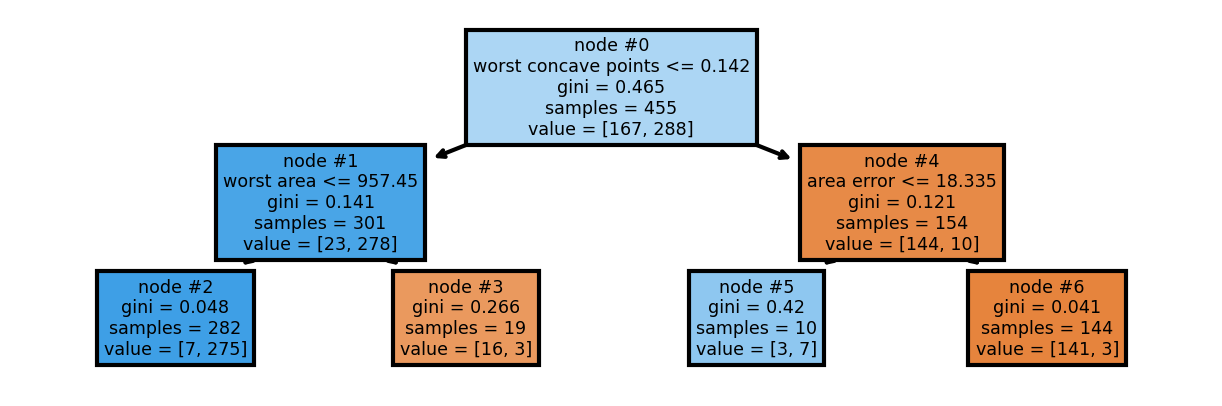

In [55]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(clf_sklearn, feature_names=X_train.columns, node_ids=True, filled=True, ax=ax);

In [56]:
clf_sklearn.tree_.weighted_n_node_samples

array([455., 301., 282.,  19., 154.,  10., 144.])

## Vanilla HS from imodels package

In [57]:
clf_sklearn_forHS = clone(clf_sklearn)

lambd = 10.

clf_hs = HSTreeClassifier(clf_sklearn_forHS, reg_param=lambd, shrinkage_scheme_="node_based")

clf_hs.fit(X_train, y_train)

In [58]:
y_pred_imodels = clf_hs.predict(X_test)

In [59]:
acc_imodels = accuracy_score(y_test, y_pred_imodels)
acc_imodels

0.9210526315789473

In [60]:
acc_imodels == acc_sklearn

True

In [61]:
clf_hs.get_params()

{'reg_param': 10.0,
 'estimator_': DecisionTreeClassifier(max_depth=2, random_state=42),
 'shrinkage_scheme_': 'node_based'}

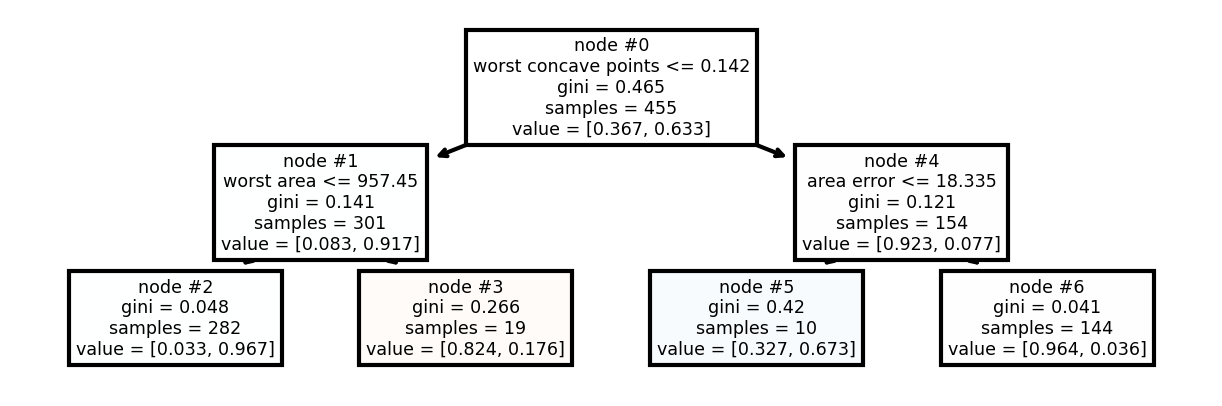

In [62]:
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(clf_hs.estimator_, feature_names=X_train.columns, node_ids=True, filled=True, ax=ax);

## TreeModels from Scratch

### Without HS

In [309]:
# Train DecisionTree from scratch
clf_tree = DecisionTree(max_depth=2, treetype="classification", HS_lambda=10, HShrinkage=False, random_state=42)
clf_tree.fit(X_train, y_train)

In [310]:
# Predict
y_pred = clf_tree.predict(X_test)

In [311]:
acc_tree_scratch = accuracy_score(y_test, y_pred)
acc_tree_scratch

0.9210526315789473

In [312]:
acc_tree_scratch == acc_sklearn

True

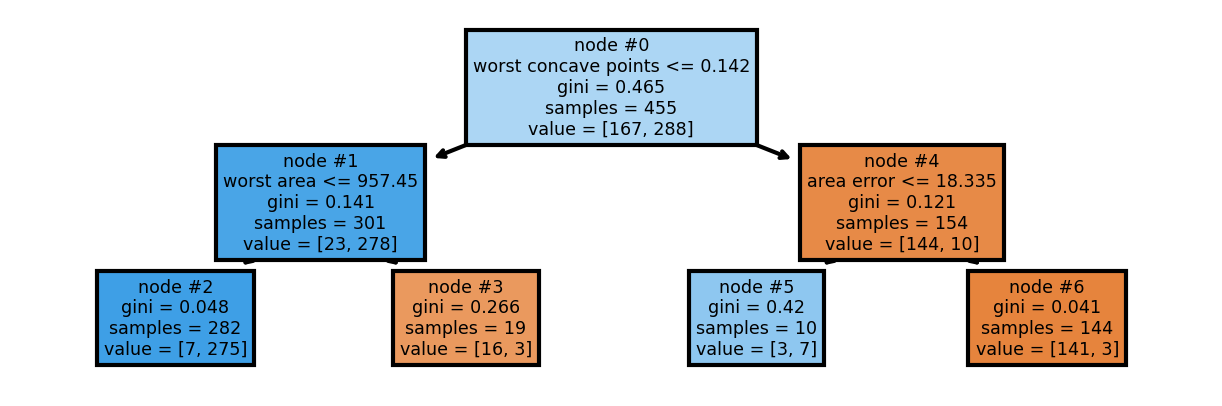

In [313]:
# Comparison with sklearn
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(clf_sklearn, feature_names=X_train.columns, node_ids=True, filled=True, ax=ax);

In [314]:
clf_tree.node_id_dict

{0: {'node': <DecisionTree.Node at 0x12d3a63e0>,
  'id': 0,
  'depth': 0,
  'feature': 'worst concave points',
  'is_leaf_node': False,
  'threshold': 0.1417,
  'gini': 0.4646395362878879,
  'samples': 455,
  'value': 1,
  'value_distribution': [167, 288],
  'prob_distribution': array([0.36703297, 0.63296703])},
 1: {'node': <DecisionTree.Node at 0x12d3a5300>,
  'id': 1,
  'depth': 1,
  'feature': 'worst area',
  'is_leaf_node': False,
  'threshold': 957.45,
  'gini': 0.14114634496307987,
  'samples': 301,
  'value': 1,
  'value_distribution': [23, 278],
  'prob_distribution': array([0.07641196, 0.92358804])},
 2: {'node': <DecisionTree.Node at 0x12d3a5660>,
  'id': 2,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 0.048413057693274864,
  'samples': 282,
  'value': 1,
  'value_distribution': [7, 275],
  'prob_distribution': array([0.0248227, 0.9751773])},
 3: {'node': <DecisionTree.Node at 0x12d3a7c40>,
  'id': 3,
  'depth': 2,
  'feature': None

In [109]:
clf_sklearn.tree_.n_outputs

1

In [110]:
clf_sklearn.tree_.weighted_n_node_samples

array([455., 301., 282.,  19., 154.,  10., 144.])

In [111]:
clf_sklearn.tree_.max_n_classes

2

In [112]:
clf_sklearn.tree_.value

array([[[167., 288.]],

       [[ 23., 278.]],

       [[  7., 275.]],

       [[ 16.,   3.]],

       [[144.,  10.]],

       [[  3.,   7.]],

       [[141.,   3.]]])

In [113]:
# node values from scratch without HS: 
node_values_scratch_clf = [node.clf_value_dis for node in clf_tree.node_list]
node_values_scratch_clf

[[167, 288], [23, 278], [7, 275], [16, 3], [144, 10], [3, 7], [141, 3]]

They are the same!

In [114]:
# node values from scratch without HS: 
[node.clf_prob_dis for node in clf_tree.node_list]

[array([0.36703297, 0.63296703]),
 array([0.07641196, 0.92358804]),
 array([0.0248227, 0.9751773]),
 array([0.84210526, 0.15789474]),
 array([0.93506494, 0.06493506]),
 array([0.3, 0.7]),
 array([0.97916667, 0.02083333])]

In [308]:
clf_sklearn.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04723352, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13020764, 0.        ,
       0.        , 0.        , 0.82255884, 0.        , 0.        ])

In [315]:
clf_tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04723352, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13020764, 0.        ,
       0.        , 0.        , 0.82255884, 0.        , 0.        ])

### With HS

In [169]:
# Train DecisionTree from scratch
clf_treeHS = DecisionTree(max_depth=2, treetype="classification", HS_lambda=lambd, HShrinkage=True, random_state=42)
clf_treeHS.fit(X_train, y_train)

In [170]:
# Predict
y_pred_scratchHS = clf_treeHS.predict(X_test)

In [171]:
acc_tree_scratchHS = accuracy_score(y_test, y_pred_scratchHS)
acc_tree_scratchHS

0.9210526315789473

In [172]:
acc_tree_scratchHS == acc_imodels

True

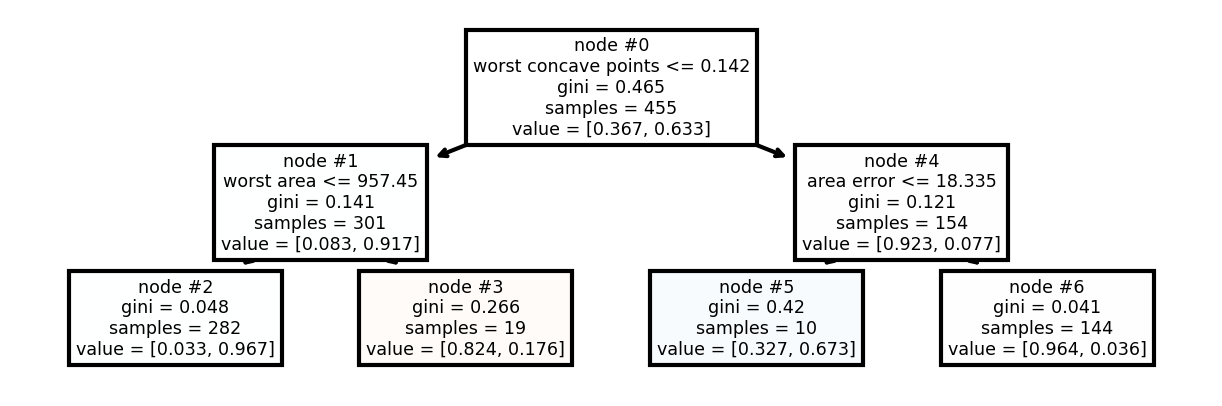

In [173]:
# Comparison with sklearn
_, ax = plt.subplots(figsize=(5,1.5))
plot_tree(clf_hs.estimator_, feature_names=X_train.columns, node_ids=True, filled=True, ax=ax);

In [174]:
clf_treeHS.node_id_dict

{0: {'node': <DecisionTree.Node at 0x12ce409a0>,
  'id': 0,
  'depth': 0,
  'feature': 'worst concave points',
  'is_leaf_node': False,
  'threshold': 0.1417,
  'gini': 0.4646395362878879,
  'samples': 455,
  'value': 1,
  'value_distribution': [167, 288],
  'prob_distribution': array([0.36703297, 0.63296703])},
 1: {'node': <DecisionTree.Node at 0x12ce43fd0>,
  'id': 1,
  'depth': 1,
  'feature': 'worst area',
  'is_leaf_node': False,
  'threshold': 957.45,
  'gini': 0.14114634496307987,
  'samples': 301,
  'value': 1,
  'value_distribution': [23, 278],
  'prob_distribution': array([0.08266187, 0.91733813])},
 2: {'node': <DecisionTree.Node at 0x12ce407f0>,
  'id': 2,
  'depth': 2,
  'feature': None,
  'is_leaf_node': True,
  'threshold': None,
  'gini': 0.048413057693274864,
  'samples': 282,
  'value': 1,
  'value_distribution': [7, 275],
  'prob_distribution': array([0.03273143, 0.96726857])},
 3: {'node': <DecisionTree.Node at 0x12ce40760>,
  'id': 3,
  'depth': 2,
  'feature': No

In [175]:
np.concatenate(clf_hs.estimator_.tree_.value)

array([[0.36703297, 0.63296703],
       [0.08266187, 0.91733813],
       [0.03273143, 0.96726857],
       [0.82373481, 0.17626519],
       [0.92284919, 0.07715081],
       [0.32650773, 0.67349227],
       [0.9642618 , 0.0357382 ]])

In [176]:
[node.clf_prob_dis for node in clf_treeHS.node_list]

[array([0.36703297, 0.63296703]),
 array([0.08266187, 0.91733813]),
 array([0.03273143, 0.96726857]),
 array([0.82373481, 0.17626519]),
 array([0.92284919, 0.07715081]),
 array([0.32650773, 0.67349227]),
 array([0.9642618, 0.0357382])]

They are equal